In [1]:
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
import numpy as np
import pandas as pd
import random
import re
import sklearn
import string
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
import datetime
from collections import Counter
from langdetect import detect

# data cleaning
import re
from zhon.hanzi import punctuation as ch_pun
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from tqdm import tqdm

# prepare for model training 
# try:
#     import transformers
#     import datasets
#     from datasets import Dataset, DatasetDict
#     assert transformers.__version__ == '4.3.3'
# except:
#     !pip install datasets==1.4.1
#     !pip install transformers==4.3.3
#     import transformers
#     import datasets
#     from datasets import Dataset, DatasetDict

# from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# modules 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Keywords extraction 
from wordcloud import WordCloud
from textblob import TextBlob
from nlp_rake import Rake

# Set the random seed for reproducibility
RAND_SEED = 27
random.seed(RAND_SEED)
np.random.seed(RAND_SEED)

[nltk_data] Error loading punkt: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11004] getaddrinfo failed>


In [2]:
directory = './'
data = pd.read_csv(directory+'legal_dataset_all.csv',encoding='utf-8')
data = data.dropna(axis = 0)
data = data.drop_duplicates(['Content'])
data = data.drop(data[data['Content']==data['Summary']].index)
data

,Content,Summary
0,"When you visit the website over http, you are ...",https is not used by default
1,YOU AND NETFLIX AGREE THAT EACH MAY BRING CLAI...,You wave your right to a class action.
2,Google may also stop providing Services to you...,Google may stop providing services to you at a...
3,We may update this Privacy Policy from time to...,"The service may change its terms at any time, ..."
4,Grammarly's Privacy Policy is easy to read. It...,The terms for this service are easy to read
...,...,...
17214,"Updated on Mar 02, 2021\n \nPrivacy notice",There is a date of the last update of the agre...
17215,Contains sexually explicit\n \nTerms of...,The posting of pornographic content is prohibited
17216,or interfere with any other user's ability to ...,You shall not interfere with another person's ...
17217,You agree to comply with all applicable laws a...,You agree not to submit illegal content


In [3]:
# This code shows how many raw clauses can be summarised by the same summary
data['Summary'].value_counts()

The service is provided 'as is' and to be used at the users' sole risk                                                 287
There is a date of the last update of the terms                                                                        281
The service may use tracking pixels, web beacons, browser fingerprinting, and/or device fingerprinting on users.       229
There is a date of the last update of the agreements                                                                   225
You agree to defend, indemnify, and hold the service harmless in case of a claim related to your use of the service    214
                                                                                                                      ... 
You waive your right to injunctive relife (a class action)                                                               1
[Neutral]  Groupon modifications to Privacy Statement                                                                    1
Third-party anal

Text(0.5, 1.03, 'Frequency distribution of summaries from high to low')

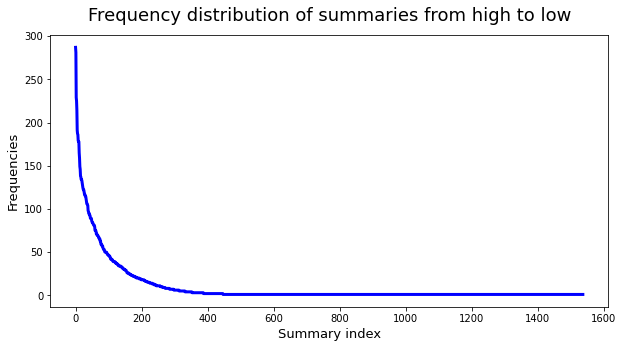

In [4]:
_ = plt.figure(figsize=(10, 5))
data['Summary'].value_counts().reset_index(drop=True).plot(color='b',linewidth=3)
plt.xlabel('Summary index',fontsize=13)
plt.ylabel('Frequencies',fontsize=13)
plt.title('Frequency distribution of summaries from high to low',fontsize=18,y=1.03)

In [5]:
def balance_dataset(val_counts, lim = 25):
    balance = val_counts.copy()
    for i in balance.index:
        freq = balance[i]
        if freq>lim:
            data.drop(data[data['Summary']== i].sample(freq - lim).index,inplace = True)

In [6]:
val_counts = data['Summary'].value_counts()
balance_dataset(val_counts)

In [7]:
data

,Content,Summary
0,"When you visit the website over http, you are ...",https is not used by default
1,YOU AND NETFLIX AGREE THAT EACH MAY BRING CLAI...,You wave your right to a class action.
2,Google may also stop providing Services to you...,Google may stop providing services to you at a...
5,At https://twitter.com/tos/previous you can se...,Twitter provide archives of their terms
6,"When you create a GitHub account, you provide ...",You must provide your legal name
...,...,...
17214,"Updated on Mar 02, 2021\n \nPrivacy notice",There is a date of the last update of the agre...
17215,Contains sexually explicit\n \nTerms of...,The posting of pornographic content is prohibited
17216,or interfere with any other user's ability to ...,You shall not interfere with another person's ...
17217,You agree to comply with all applicable laws a...,You agree not to submit illegal content


Text(0.5, 1.03, 'Frequency distribution of summaries from high to low')

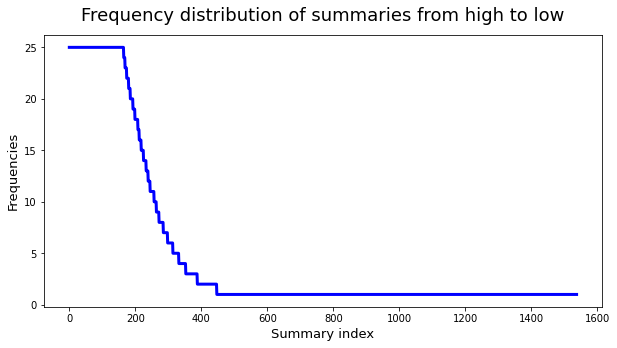

In [8]:
_ = plt.figure(figsize=(10, 5))
data['Summary'].value_counts().reset_index(drop=True).plot(color='b',linewidth=3)
plt.xlabel('Summary index',fontsize=13)
plt.ylabel('Frequencies',fontsize=13)
plt.title('Frequency distribution of summaries from high to low',fontsize=18,y=1.03)

In [9]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', ' ', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]{}<>', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'•', '', text)
    text = re.sub(r'<strong>nbsp','',text)
    text = re.sub('<p>','',text)
    text = re.sub('<li>','',text)
    text = re.sub('< li>','',text)
    for i in list(ch_pun):
        text = re.sub(i,'',text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
 
    return text

In [10]:
summary = data['Summary'].tolist()
summary = [clean_text(i, remove_stopwords = False) for i in summary]
data['Summary'] = [clean_text(i, remove_stopwords = False) for i in summary]
content = data['Content'].tolist()
content = [clean_text(j, remove_stopwords = False) for j in content]
data['Content'] = [clean_text(j, remove_stopwords = False) for j in content]

In [11]:
data = data[data.Content.map(lambda x: x.isascii())]
data = data[data.Summary.map(lambda x: x.isascii())]
summary = data['Summary'].tolist()
content = data['Content'].tolist()
data

,Content,Summary
0,"when you visit the website over http, you are ...",https is not used by default
1,you and netflix agree that each may bring clai...,you wave your right to a class action.
2,google may also stop providing services to you...,google may stop providing services to you at a...
5,at,twitter provide archives of their terms
6,"when you create a github account, you provide ...",you must provide your legal name
...,...,...
17214,"updated on mar 02, 2021 privacy notice",there is a date of the last update of the agre...
17215,contains sexually explicit terms of use,the posting of pornographic content is prohibited
17216,or interfere with any other user s ability to ...,you shall not interfere with another person s ...
17217,you agree to comply with all applicable laws a...,you agree not to submit illegal content


In [12]:
try:
    nlp = spacy.load("en_core_web_md")
except OSError:
    import spacy.cli 
    print("Model not found. Downloading.")
    spacy.cli.download("en_core_web_md")
    import en_core_web_md
    nlp = en_core_web_md.load()
    
def spacy_word_tokenize(text):
    return [token.text for token in nlp(text)]

sum_tokens = [spacy_word_tokenize(i) for i in tqdm(summary)]
cont_tokens = [spacy_word_tokenize(i) for i in tqdm(content)]

100%|██████████████████████████████████████████████████████████████████████████████| 7038/7038 [01:28<00:00, 79.61it/s]


In [13]:
summary_len = [len(i) for i in sum_tokens]
content_len = [len(i) for i in cont_tokens]

Text(0.5, 1.02, 'Distribution of summary length before cleaning')

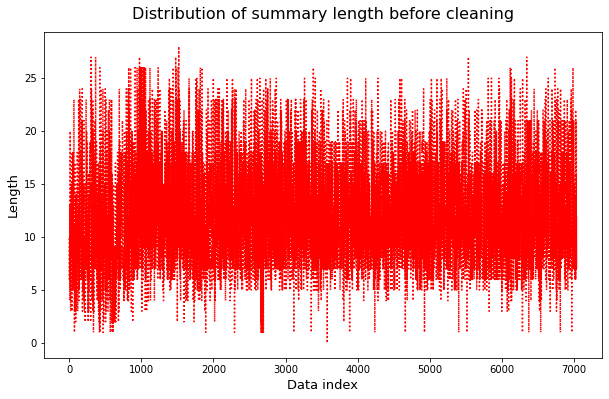

In [16]:
_ = plt.figure(figsize=(10, 6))
_ = plt.plot([i for i in range(len(summary_len))],summary_len,':',color='red')
plt.xlabel('Data index',fontsize=13)
plt.ylabel('Length',fontsize=13)
plt.title('Distribution of summary length before cleaning',fontsize=16,y=1.02)

Text(0.5, 1.02, 'Distribution of content length before cleaning')

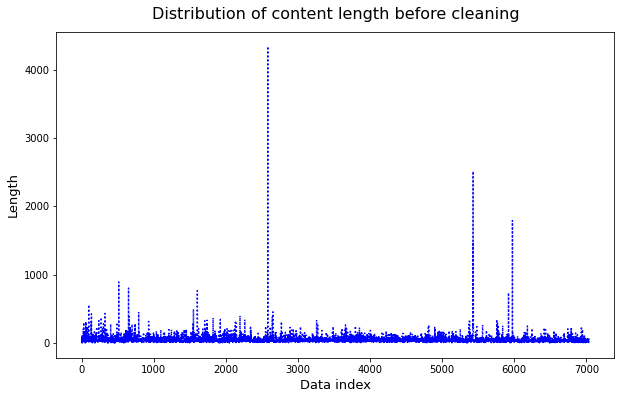

In [17]:
_ = plt.figure(figsize=(10, 6))
_ = plt.plot([i for i in range(len(content_len))],content_len,':',color='blue')
plt.xlabel('Data index',fontsize=13)
plt.ylabel('Length',fontsize=13)
plt.title('Distribution of content length before cleaning',fontsize=16,y=1.02)

In [18]:
summary_len = [len(i) for i in sum_tokens]
content_len = [len(i) for i in cont_tokens]

In [19]:
len(summary_len)

7038

In [20]:
def get_long_short_idx(len_list,content = False):
    idx = []
    record = 0
    for len_ in tqdm(len_list):
        if not content:
            if len_ > 300 or len_ < 5:
                idx.append(record)
        else:
            if len_ > 300 or len_ < 15:
                idx.append(record)
        record += 1
    return idx

bad_summary = get_long_short_idx(summary_len)
bad_content = get_long_short_idx(content_len, content = True)
bad_idx = bad_summary + bad_content
bad_idx = set(bad_idx)
len(bad_idx)

100%|█████████████████████████████████████████████████████████████████████████| 7038/7038 [00:00<00:00, 2322176.81it/s]


1004

In [21]:
1-1012/7036

0.8561682774303582

In [22]:
sum_tokens = [sum_tokens[i] for i in range(len(sum_tokens)) if i not in bad_idx]
cont_tokens = [cont_tokens[i] for i in range(len(cont_tokens)) if i not in bad_idx]
summary_len = [len(i) for i in sum_tokens]
content_len = [len(i) for i in cont_tokens]

Text(0.5, 1.02, 'Distribution of summary length after cleaning')

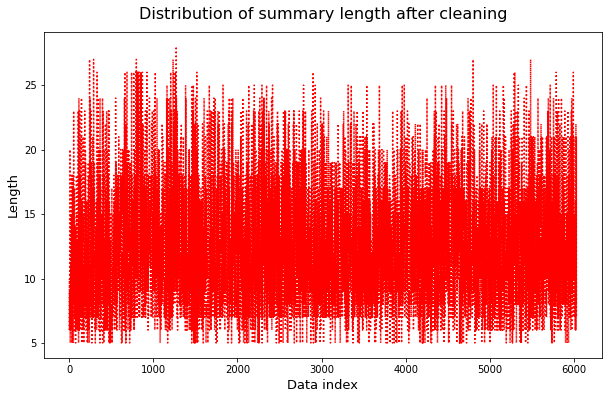

In [25]:
_ = plt.figure(figsize=(10, 6))
_ = plt.plot([i for i in range(len(summary_len))],summary_len,':',color='red')
plt.xlabel('Data index',fontsize=13)
plt.ylabel('Length',fontsize=13)
plt.title('Distribution of summary length after cleaning',fontsize=16,y=1.02)

Text(0.5, 1.02, 'Distribution of content length after cleaning')

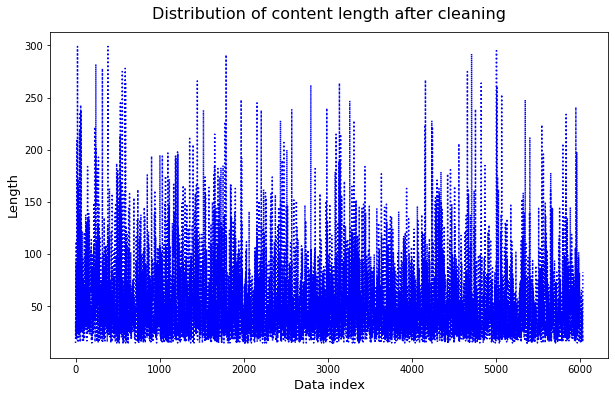

In [26]:
_ = plt.figure(figsize=(10, 6))
_ = plt.plot([i for i in range(len(content_len))],content_len,':',color='blue')
plt.xlabel('Data index',fontsize=13)
plt.ylabel('Length',fontsize=13)
plt.title('Distribution of content length after cleaning',fontsize=16,y=1.02)

In [95]:
def get_large_list(obj):
    flatten = []
    for i in tqdm(obj):
        flatten += i
    return flatten

In [96]:
sum_count = get_large_list(sum_tokens)
print(len(sum_count))
cont_count = get_large_list(cont_tokens)
print(len(cont_count))

100%|██████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 465399.60it/s]

74009
314012


In [97]:
sum_freq = Counter(sum_count)
cont_freq = Counter(cont_count)
print("There are {} tokens in summaries.".format(len(sum_freq)))
print("There are {} tokens in contents.".format(len(cont_freq)))

There are 1583 tokens in summaries.
There are 11162 tokens in contents.


In [100]:
def plot_freq_distribution(frequencies,obj):
    figure = plt.figure(figsize=(18, 8))
    keys, values = zip(*frequencies)
    plt.bar(keys, values)
    plt.title(f"{obj} token frequency distribution",fontsize=16,y=1.02)
    plt.xticks(rotation=90)
    plt.show()

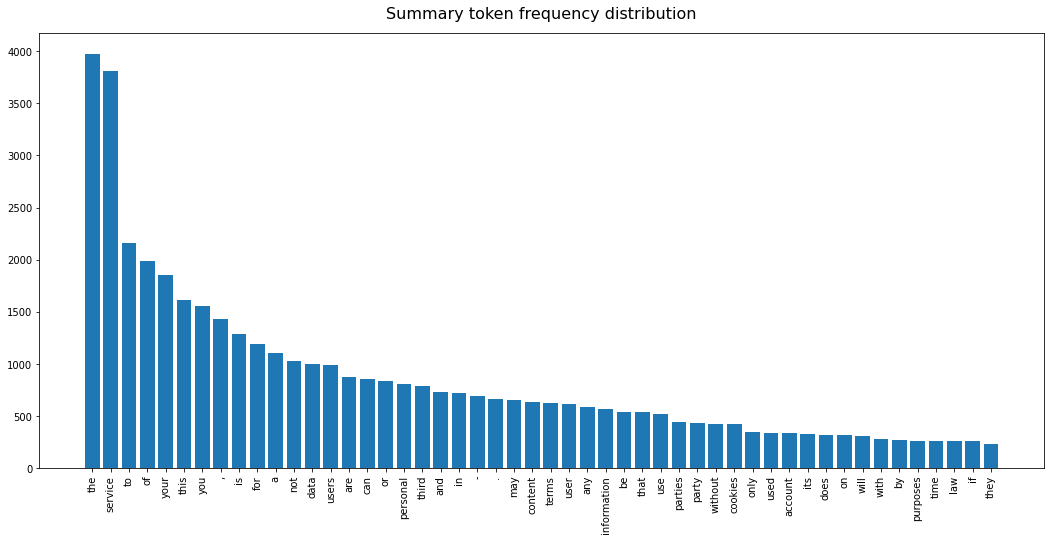

In [101]:
plot_freq_distribution(sum_freq.most_common(50)[:],'Summary')

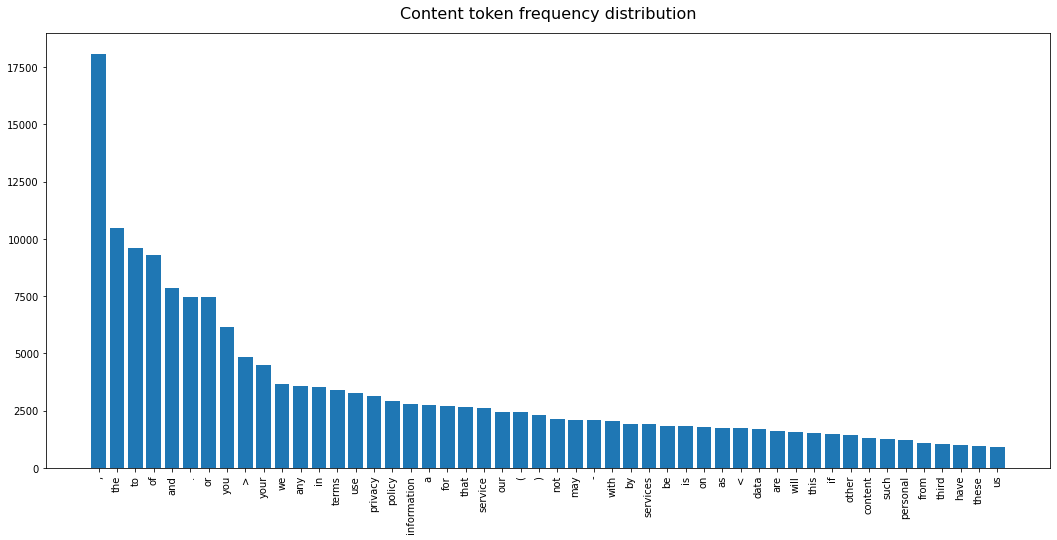

In [102]:
plot_freq_distribution(cont_freq.most_common(50)[:],'Content')

In [67]:
def drop_spaces(obj):
    '''
    remove the spaces which sometimes be tokenised.
    
    '''
    drop = obj.copy()
    for i in tqdm(range(len(drop))):
        drop[i] = [j for j in drop[i] if j !=' ' and j != '']
    return drop

In [68]:
sum_tokens = drop_spaces(sum_tokens)
cont_tokens = drop_spaces(cont_tokens)

100%|███████████████████████████████████████████████████████████████████████████| 6024/6024 [00:00<00:00, 50745.29it/s]


In [69]:
sum_count = get_large_list(sum_tokens)
print(len(sum_count))
cont_count = get_large_list(cont_tokens)
print(len(cont_count))
sum_freq = Counter(sum_count)
cont_freq = Counter(cont_count)
print("There are {} tokens in summaries.".format(len(sum_freq)))
print("There are {} tokens in contents.".format(len(cont_freq)))

100%|█████████████████████████████████████████████████████████████████████████| 6024/6024 [00:00<00:00, 1509708.85it/s]


73902


100%|██████████████████████████████████████████████████████████████████████████| 6024/6024 [00:00<00:00, 604143.45it/s]

306773
There are 1583 tokens in summaries.
There are 10921 tokens in contents.


In [70]:
def OOV_replacement(token_obj, dic_obj, lim = 2):
    '''
    words appear less than or equal to lim times will be marked as OOV.
    token_obj: list of tokens
    dic_obj: a dictionary with words as keys and count as values
    
    '''
    OOV = []
    for i,j in dic_obj.items():
        if j <= lim:
            OOV.append(i)
    tokens = token_obj.copy()
    for idx in tqdm(range(len(tokens))):
        tokens[idx] = [token if token not in OOV else 'OOV' for token in tokens[idx]]
    return tokens
                
def flat_list(obj):
    flatten = []
    for i in obj:
        for j in i:
            flatten.append(j)
    return flatten
def load_summary():
    vocab = [line for line in sum_set]
    basicw2i = {'<OOV>': 0, '<Blank>': 1, '<SoS>': 2, '<EoS>': 3}
    basici2w = {j:i for i,j in basicw2i.items()}
    word2idx = {word: idx + 4 for idx, word in enumerate(vocab)}
    idx2word = {idx + 4: word for idx, word in enumerate(vocab)}
    basicw2i.update(word2idx)
    basici2w.update(idx2word)
    return basicw2i, basici2w

def load_content():
    vocab = [line for line in cont_set]
    basicw2i = {'<OOV>': 0, '<Blank>': 1, '<SoS>': 2, '<EoS>': 3}
    basici2w = {j:i for i,j in basicw2i.items()}
    word2idx = {word: idx + 4 for idx, word in enumerate(vocab)}
    idx2word = {idx + 4: word for idx, word in enumerate(vocab)}
    basicw2i.update(word2idx)
    basici2w.update(idx2word)
    return basicw2i, basici2w

def create_data(source_sents, target_sents): 
    sum2idx, idx2sum = load_summary()
    cont2idx, idx2cont = load_content()     
    
def text_to_idx(token_obj,dic_obj):
    '''
    transfer tokens into indices.
    token_obj: list of tokens
    dic_obj: a dictionary with words as keys and count as values
    
    '''
    token = token_obj.copy()
    for idx in tqdm(range(len(token_obj))):
        token[idx] = [dic_obj[i] for i in token[idx]]
    return token

def add_SoS_EoS(idx_obj,SoS = True, EoS = True):
    '''
    add <SoS>, <EoS> to the tokenised sentences
    idx_obj: list of tokens that are transformed into indices
    
    '''
    obj = idx_obj.copy()
    for idx in tqdm(range(len(idx_obj))):
        if SoS:
            obj[idx] = [2] + obj[idx] 
        if EoS:
            obj[idx] = obj[idx] + [3]
    return obj

def blank_filling(idx_obj, tgt = False, inputs = False):
    '''
    fill the sentences with <Blank> to ensure sentence length consistency
    idx_obj: list of tokens that are transformed into indices
    
    '''
    obj = idx_obj.copy()
    max_len = max([len(i) for i in obj])
    print('Maximum length is {}'.format(max_len))
    for idx in tqdm(range(len(obj))):
        if inputs == True:
            obj[idx] = obj[idx][:-1]
        current_len = len(obj[idx])
        obj[idx] = obj[idx] + [1] * (max_len - current_len)
        if tgt == True:
            obj[idx] = obj[idx][1:] + [1]
    print('Current length is {}'.format(len(obj[idx])))
    return obj    

In [71]:
sum_tokens = OOV_replacement(sum_tokens,sum_freq)
cont_tokens = OOV_replacement(cont_tokens,cont_freq)

100%|█████████████████████████████████████████████████████████████████████████████| 6024/6024 [00:26<00:00, 223.91it/s]


In [72]:
sum_set = set(flat_list(sum_tokens))
cont_set = set(flat_list(cont_tokens))
sum_w2i,sum_i2w = load_summary()
cont_w2i,cont_i2w = load_content()

In [73]:
len(cont_w2i)

4390

In [74]:
import json
import os
def save_json(dic_subject, root_dir, file_name):
    with open(root_dir + file_name, 'w') as f:
        json.dump(dic_subject, f)
    print('done!')

    
root_dir = './'
file_name = 'cont_w2i_all.json'
dic_subject = cont_w2i
save_json(dic_subject, root_dir, file_name)

file_name = 'sum_w2i_all.json'
dic_subject = sum_w2i
save_json(dic_subject, root_dir, file_name)

done!
done!


In [75]:
sum_idx = text_to_idx(sum_tokens,sum_w2i)
sum_idx = add_SoS_EoS(sum_idx)
sum_idx_1 = blank_filling(sum_idx, tgt = True)
sum_idx = blank_filling(sum_idx, inputs = True)
cont_idx = text_to_idx(cont_tokens,cont_w2i)
cont_idx = add_SoS_EoS(cont_idx)
cont_idx = blank_filling(cont_idx)

100%|██████████████████████████████████████████████████████████████████████████| 6024/6024 [00:00<00:00, 862690.77it/s]


Maximum length is 30


100%|██████████████████████████████████████████████████████████████████████████| 6024/6024 [00:00<00:00, 464722.31it/s]


Current length is 30
Maximum length is 30


100%|█████████████████████████████████████████████████████████████████████████| 6024/6024 [00:00<00:00, 1207593.91it/s]


Current length is 30


100%|██████████████████████████████████████████████████████████████████████████| 6024/6024 [00:00<00:00, 464602.68it/s]


Maximum length is 301


100%|██████████████████████████████████████████████████████████████████████████| 6024/6024 [00:00<00:00, 335571.06it/s]

Current length is 301


In [76]:
idx_data = pd.DataFrame({'Content':cont_idx,'Summary':sum_idx, 'Tgt_Summary':sum_idx_1})
idx_data.head()

,Content,Summary,Tgt_Summary
0,"[2, 1754, 2180, 4208, 3683, 83, 122, 761, 3403...","[2, 589, 165, 334, 145, 289, 625, 1, 1, 1, 1, ...","[589, 165, 334, 145, 289, 625, 3, 1, 1, 1, 1, ..."
1,"[2, 2180, 1964, 2935, 2420, 3702, 3290, 867, 3...","[2, 8, 241, 408, 855, 389, 698, 488, 530, 229,...","[8, 241, 408, 855, 389, 698, 488, 530, 229, 3,..."
2,"[2, 952, 867, 4125, 181, 1289, 1436, 463, 2180...","[2, 776, 694, 134, 185, 307, 389, 8, 498, 809,...","[776, 694, 134, 185, 307, 389, 8, 498, 809, 62..."
3,"[2, 1754, 2180, 2739, 4204, 2158, 3871, 3403, ...","[2, 8, 455, 359, 408, 814, 284, 1, 1, 1, 1, 1,...","[8, 455, 359, 408, 814, 284, 3, 1, 1, 1, 1, 1,..."
4,"[2, 2988, 836, 3683, 1050, 463, 2529, 989, 430...","[2, 90, 656, 703, 662, 222, 312, 8, 580, 397, ...","[90, 656, 703, 662, 222, 312, 8, 580, 397, 3, ..."


In [77]:
idx_data.to_csv('idx_data_all.csv', index = False)

Text(0.5, 1.03, 'ROUGE Score Comparison Between Models')

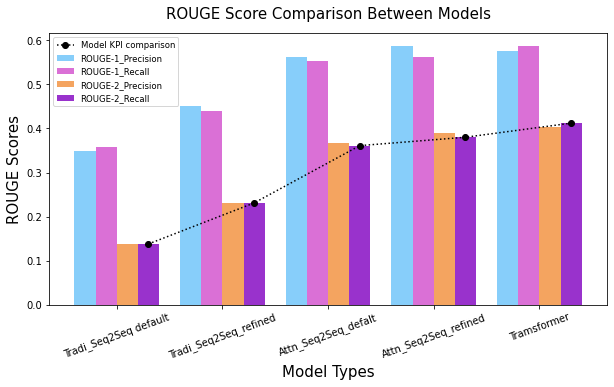

In [3]:
cat = ['Tradi_Seq2Seq default','Tradi_Seq2Seq_refined','Attn_Seq2Seq_defalt','Attn_Seq2Seq_refined','Tramsformer']
ROUGE_1p = [0.348,0.450,0.563,0.587,0.575]
ROUGE_1r = [0.359,0.439,0.552,0.563,0.587]
ROUGE_2p = [0.139,0.232,0.368,0.390,0.404]
ROUGE_2r = [0.138,0.231,0.361,0.380,0.412]
bar_width = 0.2 # Define the bar width so each bar will fit!
x1_pos = [0,1,2,3,4]
x2_pos = [x+bar_width for x in x1_pos]
x3_pos = [x+bar_width for x in x2_pos]
x4_pos = [x+bar_width for x in x3_pos]#that the value and add it with line width
x_label = [0.3,1.3,2.3,3.3,4.3]
no_of_bars = len(cat)
plt.figure(figsize=(10,5))

bar1 = plt.bar(x1_pos,
               ROUGE_1p, 
               width = bar_width,
               color ='lightskyblue',
               label ='ROUGE-1_Precision')

bar2 = plt.bar(x2_pos, 
               ROUGE_1r, 
               width = bar_width,
               color ='orchid',
               label ='ROUGE-1_Recall')
bar3 = plt.bar(x3_pos, 
               ROUGE_2p, 
               width = bar_width,
               color ='sandybrown',
               label ='ROUGE-2_Precision')
bar4 = plt.bar(x4_pos, 
               ROUGE_2r, 
               width = bar_width,
               color ='darkorchid',
               label ='ROUGE-2_Recall')
_ = plt.plot(x4_pos,ROUGE_2r,'o:',color='black',label = 'Model KPI comparison')

plt.xticks(x_label, cat,rotation=20)
plt.xlabel("Model Types",fontsize=15)
plt.ylabel("ROUGE Scores",fontsize=15)
plt.legend(loc='upper left', frameon=True,fontsize=8.5)
plt.tick_params(labelsize=10)
plt.title("ROUGE Score Comparison Between Models",fontsize=15,y=1.03)

Text(0.5, 1.02, 'Training Speed Comparison Between Models')

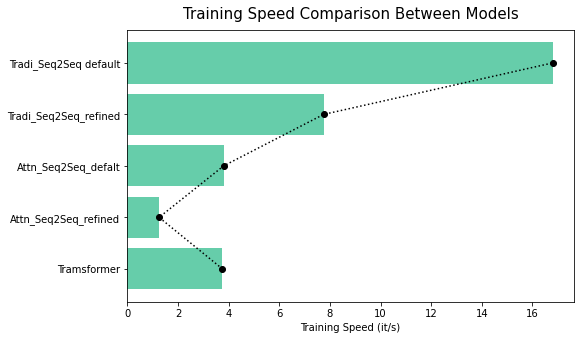

In [80]:
speed = [16.8,7.75,3.8,1.25,3.75][::-1]
plt.figure(figsize=(8,5))
plt.barh(cat[::-1],speed,color='mediumaquamarine')
plt.plot(speed,cat[::-1],'o:',color='black')
plt.xlabel('Training Speed (it/s)')
plt.title('Training Speed Comparison Between Models',fontsize=15,y=1.02)